In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
from Scripts.clean import all_clean
from Scripts.visualization import all_viz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [2]:
C = all_clean()
V = all_viz()

#### Load data 

In [3]:
data = C.read_csv('../data/data-cleaned.csv')

In [4]:
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.118400,0.22862,0.28241,0.14710,0.2419,0.07871,...,17.33,184.60,1937.05,0.1622,0.62695,0.7119,0.2654,0.41915,0.11890,M
1,20.57,17.77,132.90,1326.0,0.084740,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1937.05,0.1238,0.18660,0.2416,0.1860,0.27500,0.08902,M
2,19.69,21.25,130.00,1203.0,0.109600,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.00,0.1444,0.42450,0.4504,0.2430,0.36130,0.08758,M
3,11.42,20.38,77.58,386.1,0.133695,0.22862,0.24140,0.10520,0.2464,0.07875,...,26.50,98.87,567.70,0.1901,0.62695,0.6869,0.2575,0.41915,0.12301,M
4,20.29,14.34,135.10,1297.0,0.100300,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.00,0.1374,0.20500,0.4000,0.1625,0.23640,0.07678,M


##### Independent and dependent variables

In [5]:
X = data.iloc[:,:-1]
y = (data.diagnosis).map(lambda x: 1 if x == "M" else 0 )

In [6]:
X_scaled = C.scaler(X,X.columns,mode="minmax")

## selected features based on correlation 

In [7]:
correlation = pd.DataFrame(X_scaled.corrwith(y)).sort_values(by=0, ascending=False)
correlation.rename({0: "diagnosis"}, axis=1,inplace=True)

### top 10 feature with high correlation with dependent variable
top_10_feat_corr = correlation.head(10).index.tolist()
top_10_feat_corr

['perimeter_worst',
 'area_worst',
 'radius_worst',
 'concave points_worst',
 'concave points_mean',
 'perimeter_mean',
 'area_mean',
 'radius_mean',
 'area_se',
 'concavity_mean']

In [8]:
X_scaled_corr = X_scaled[top_10_feat_corr]

In [9]:
X_train_corr,X_test_corr,y_train_corr,y_test_corr = train_test_split(X_scaled_corr,y,test_size=0.2,random_state=42)

In [10]:
def accuracy(X, X1, y, y1):
    """
    --find accuracy using random forest
    """
    rf = RandomForestClassifier()
    rf = rf.fit(X,y)

    acc = accuracy_score(y1,rf.predict(X1))
    print(f'the accuracy is {acc}')

In [11]:
accuracy(X_train_corr,X_test_corr,y_train_corr,y_test_corr)

the accuracy is 0.956140350877193


## Univariate feature selection using chi 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [13]:
select_feature = SelectKBest(chi2, k=10).fit(X_train, y_train)

In [14]:
### a dic of features and scores 

Feat_scores = {}
score_list = list(select_feature.scores_)
for key in X_train.columns:
    for value in score_list:
        Feat_scores[key] = value
        score_list.remove(value)
        break 

In [15]:
feat_scores_sorted = sorted(Feat_scores.items(), key=lambda x: x[1], reverse=True)


In [16]:
top_10_feat_chi = list((dict(feat_scores_sorted[0:10])).keys())
top_10_feat_chi

['area_se',
 'area_worst',
 'concave points_mean',
 'concavity_mean',
 'area_mean',
 'concavity_worst',
 'perimeter_worst',
 'concave points_worst',
 'radius_worst',
 'radius_se']

In [17]:
X_scaled_chi = X_scaled[top_10_feat_chi]

In [18]:
X_train_chi,X_test_chi,y_train_chi,y_test_chi = train_test_split(X_scaled_chi,y,test_size=0.2,random_state=42)

In [19]:
accuracy(X_train_chi,X_test_chi,y_train_chi,y_test_chi)

the accuracy is 0.956140350877193


## feature selection using feature importance 

In [20]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [21]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

df_features = pd.DataFrame(feat_importances)
df_ = df_features.reset_index().rename(columns={'index':'Features',0:'importance'})
df_.head(10)

,Features,importance
0,concave points_worst,0.122865
1,concave points_mean,0.121965
2,area_worst,0.121858
3,perimeter_worst,0.113464
4,radius_worst,0.080745
5,concavity_mean,0.056693
6,radius_mean,0.048972
7,perimeter_mean,0.038793
8,area_mean,0.038746
9,area_se,0.034374


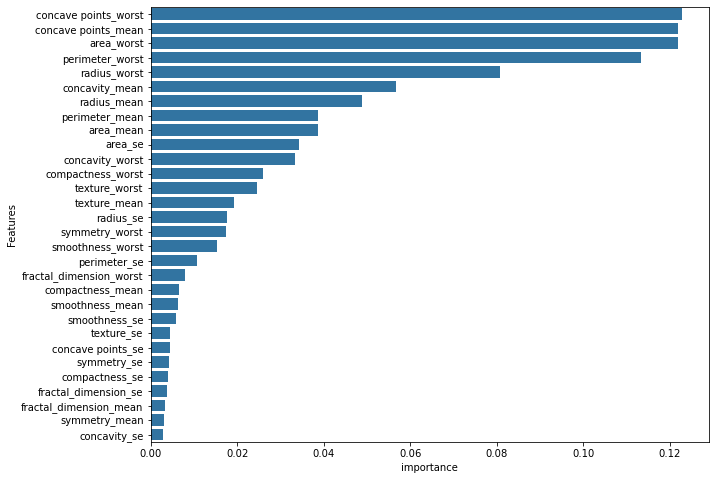

In [22]:
plt.figure(figsize=(10,8))
sns.barplot(x="importance", y="Features", data=df_,color=sns.color_palette()[0]);

In [23]:
selected = SelectFromModel(RandomForestClassifier(n_estimators = 100))
selected.fit(X_train, y_train)
selected.get_support()
selected_features= X.columns[(selected.get_support())]
top_feat_import = selected_features.tolist()
top_feat_import

['perimeter_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

In [24]:
X_scaled_imp = X_scaled[top_feat_import]

In [25]:
X_train_imp,X_test_imp,y_train_imp,y_test_imp = train_test_split(X_scaled_imp,y,test_size=0.2,random_state=42)

In [26]:
accuracy(X_train_imp,X_test_imp,y_train_imp,y_test_imp)

the accuracy is 0.956140350877193


after doing feature selection, I was decided to select 11 features from 30 given 

In [28]:
selected_features = ['perimeter_worst',
 'area_worst',
 'radius_worst',
 'concave points_worst',
 'concave points_mean',
 'perimeter_mean',
 'area_mean',
 'radius_mean',
 'area_se',
 'concavity_mean','concavity_worst']

In [29]:
X_selected = data.iloc[:,:-1][selected_features]

In [31]:
df_selected = X_selected.join(y)

In [33]:
df_selected.head()

,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,concavity_mean,concavity_worst,diagnosis
0,184.60,1937.05,25.38,0.2654,0.14710,122.80,1001.0,17.99,86.20,0.28241,0.7119,1
1,158.80,1937.05,24.99,0.1860,0.07017,132.90,1326.0,20.57,74.08,0.08690,0.2416,1
2,152.50,1709.00,23.57,0.2430,0.12790,130.00,1203.0,19.69,86.20,0.19740,0.4504,1
3,98.87,567.70,14.91,0.2575,0.10520,77.58,386.1,11.42,27.23,0.24140,0.6869,1
4,152.20,1575.00,22.54,0.1625,0.10430,135.10,1297.0,20.29,86.20,0.19800,0.4000,1


In [34]:
C.save_csv(df_selected,'../data/data-selected.csv')